# Courier Service Performance Analysis 
This project analyzes courier shipment data to evaluate delivery efficiency, customer satisfaction, and company competitiveness.  
Using SQL and Python, it explores how shipping mode, cost, and service quality relate to delivery performance.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3





### Helpeer Functions 
These functions simplify repetitive task like loading data, calculating average ratings, and computing late delivery percentages.
they improve readability and reusability in the analysis workflow

In [2]:
# --- Helper Functions --- 
def load_csv(path):
    """Loads a CSV file and returns a pandas DataFrame."""
    return pd.read_csv(path)

def get_avg_rating(df):
    """Returns the average customer rating"""
    return round(df['Customer_Rating'].mean(), 2)

def get_late_ratio(df):
    """Returns the percent of late deliveries"""
    return round(df["Late_Indicator"].mean() * 100, 2)
    

In [3]:
# Load datasets

df = pd.read_csv("../data/Train.csv")
tsi_df = pd.read_csv("../data/freight_tsi.csv")
couriers_df = pd.read_csv("../data/courier_companies.csv")



print("Train.csv columns:", df.columns.tolist())
print("freight_tsi.csv columns:", tsi_df.columns.tolist())

Train.csv columns: ['ID', 'Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Product_importance', 'Gender', 'Discount_offered', 'Weight_in_gms', 'Reached.on.Time_Y.N']
freight_tsi.csv columns: ['observation_date', 'TSIFRGHT']


In [4]:
# Connect to your existing SQLite database
conn = sqlite3.connect("../data/courier.db")


# Save as a new table in SQLite
couriers_df.to_sql("courier_companies", conn, if_exists="replace", index=False)

print("courier_companies table added successfully!")

# Verify the data
preview = pd.read_sql_query("SELECT * FROM courier_companies LIMIT 5;", conn)
print(preview)

conn.close()

courier_companies table added successfully!
   company_id      company_name  mode  avg_cost  avg_delivery_days  \
0           1     FedEx Express   Air       210                1.2   
1           2           UPS Air   Air       200                1.3   
2           3     USPS Priority  Road       160                2.0   
3           4       DHL Freight  Ship       180                3.4   
4           5  Amazon Logistics  Road       170                1.8   

   customer_rating  market_share  
0              4.7          0.22  
1              4.6          0.20  
2              4.3          0.18  
3              4.5          0.15  
4              4.4          0.10  


# 

## This query joins courier_data with courier_companies to evaluate each carrier. 
We group by company and compare (1) average discount and (2) late-delivery ratio.
Lower avg_late_ratio = more reliable; higher avg_discount = more competitive.

In [5]:
# Clean up
df.rename(columns={"Reached.on.Time_Y.N": "Late_Indicator"}, inplace=True)

# Connect to SQLite
conn = sqlite3.connect("../data/courier.db")

# --- Load freight_tsi table ---
tsi_df.to_sql("freight_tsi", conn, if_exists="replace", index=False)


# Create a Date column (since Train.csv doesn't include one)
df["Date"] = pd.date_range(start="2020-01-01", periods=len(df), freq="D")

# Convert datetime for merging
tsi_df["observation_date"] = pd.to_datetime(tsi_df["observation_date"])

print("Columns cleaned and Date column created successfully!")

print(df.head())


Columns cleaned and Date column created successfully!
   ID Warehouse_block Mode_of_Shipment  Customer_care_calls  Customer_rating  \
0   1               D           Flight                    4                2   
1   2               F           Flight                    4                5   
2   3               A           Flight                    2                2   
3   4               B           Flight                    3                3   
4   5               C           Flight                    2                2   

   Cost_of_the_Product  Prior_purchases Product_importance Gender  \
0                  177                3                low      F   
1                  216                2                low      M   
2                  183                4                low      M   
3                  176                4             medium      M   
4                  184                3             medium      F   

   Discount_offered  Weight_in_gms  Late_Indicator

In [6]:
# --- Split courier data into normalized tables ---
# 1. Customer table
customer_df = df[["Gender", "Customer_care_calls", "Customer_rating"]].copy()
customer_df = customer_df.reset_index().rename(columns={"index": "customer_ID"})
customer_df.to_sql("customer", conn, if_exists="replace", index=False)

10999

In [7]:
# 2. Product table
product_df = df[["Product_importance", "Cost_of_the_Product", "Weight_in_gms", "Prior_purchases"]].copy()
product_df = product_df.reset_index().rename(columns={"index": "product_ID"})
product_df.to_sql("product", conn, if_exists="replace", index=False)

10999

In [8]:
# 3. Courier data (fact table)
courier_df = df[[
    "Warehouse_block", "Mode_of_Shipment", "Discount_offered", "Late_Indicator"
]].copy()

In [9]:
print(df.columns.tolist())
print(tsi_df.columns.tolist())

['ID', 'Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Product_importance', 'Gender', 'Discount_offered', 'Weight_in_gms', 'Late_Indicator', 'Date']
['observation_date', 'TSIFRGHT']


In [10]:
# Add keys to connect
courier_df["customer_ID"] = customer_df["customer_ID"]
courier_df["product_ID"] = product_df["product_ID"]

In [11]:
# Add fake observation date alignment (optional)
courier_df["observation_date"] = pd.date_range(start="2020-01-01", periods=len(df), freq="D")

In [12]:
# Add primary key
courier_df = courier_df.reset_index().rename(columns={"index": "ID"})

In [13]:
# Save to DB
courier_df.to_sql("courier_data", conn, if_exists="replace", index=False)

conn.close()

print("Normalized data successfully loaded into SQLite!")

Normalized data successfully loaded into SQLite!


In [14]:
# Create Date column if not already present
if "Date" not in df.columns:
    df["Date"] = pd.date_range(start="2020-01-01", periods=len(df), freq="D")


In [15]:
df["Date"] = pd.to_datetime(df["Date"])
tsi_df["observation_date"] = pd.to_datetime(tsi_df["observation_date"])


In [16]:
# Merge with Freight Index 

merged_df = pd.merge(df, tsi_df, left_on="Date", right_on="observation_date", how="inner")
print("Merge completed successfully! Rows:", len(merged_df))
merged_df.head()

Merge completed successfully! Rows: 68


,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Late_Indicator,Date,observation_date,TSIFRGHT
0,1,D,Flight,4,2,177,3,low,F,44,1233,1,2020-01-01,2020-01-01,135.4
1,32,F,Ship,5,3,257,2,low,F,61,3341,1,2020-02-01,2020-02-01,135.1
2,61,D,Ship,3,1,221,3,low,F,64,2794,1,2020-03-01,2020-03-01,133.9
3,92,F,Ship,5,5,286,3,low,F,18,3163,1,2020-04-01,2020-04-01,123.8
4,122,F,Road,3,3,205,3,medium,F,19,2167,1,2020-05-01,2020-05-01,125.5


In [17]:
pd.merge(df, tsi_df, left_on="Date", right_on="observation_date", how="inner")

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Late_Indicator,Date,observation_date,TSIFRGHT
0,1,D,Flight,4,2,177,3,low,F,44,1233,1,2020-01-01,2020-01-01,135.4
1,32,F,Ship,5,3,257,2,low,F,61,3341,1,2020-02-01,2020-02-01,135.1
2,61,D,Ship,3,1,221,3,low,F,64,2794,1,2020-03-01,2020-03-01,133.9
3,92,F,Ship,5,5,286,3,low,F,18,3163,1,2020-04-01,2020-04-01,123.8
4,122,F,Road,3,3,205,3,medium,F,19,2167,1,2020-05-01,2020-05-01,125.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,1918,B,Flight,5,4,242,3,high,F,2,3564,1,2025-04-01,2025-04-01,137.6
64,1948,B,Ship,3,2,116,2,low,F,22,1430,1,2025-05-01,2025-05-01,137.0
65,1979,C,Ship,3,4,268,2,high,F,39,2822,1,2025-06-01,2025-06-01,137.0
66,2009,C,Ship,3,2,134,3,medium,F,54,1932,1,2025-07-01,2025-07-01,139.0


In [18]:
print(df.dtypes[["Date"]])
print(tsi_df.dtypes[["observation_date"]])


Date    datetime64[ns]
dtype: object
observation_date    datetime64[ns]
dtype: object


In [19]:
# Create SQLite database file
conn = sqlite3.connect("../data/courier.db")

# Write both datasets to tables
df.to_sql("courier_data", conn, if_exists="replace", index=False)
tsi_df.to_sql("freight_tsi", conn, if_exists="replace", index=False)

print("Database create successfully with both tables.")

Database create successfully with both tables.


# # SQL 1: Shipment Efficiency by Mode 

**Question:** Which shipment mode delivers the best service efficiency - combining average customer rating, shipment cost, and delay rate?  

In [20]:
### SQL 1: Shipment Efficiency by Mode

query1 = """
SELECT 
    c.Mode_of_Shipment,
    ROUND(AVG(c.Customer_rating), 2) AS Avg_Rating,
    ROUND(AVG(c.Cost_of_the_Product), 2) AS Avg_Cost,
    ROUND(AVG(c.Late_Indicator), 2) AS Avg_Late_Ratio
FROM courier_data AS c
GROUP BY c.Mode_of_Shipment
ORDER BY Avg_Rating DESC;
"""

result1 = pd.read_sql_query(query1, sqlite3.connect("../data/courier.db"))
print(result1)

  Mode_of_Shipment  Avg_Rating  Avg_Cost  Avg_Late_Ratio
0             Road        3.00    210.48            0.59
1             Ship        2.99    210.34            0.60
2           Flight        2.98    209.31            0.60


## This query compares average ratings, shipment mode, shipment cost and late delivery ratio.
Shipment by Ship showed the highest satisfaction and fewer delays, while Air was slightly faster but more expensive.

## This query compares the three shipment modes—**Air, Ship, and Road**—on their average  
customer rating,  
shipment cost, and  
late-delivery ratio.  

## The results show how different transport types perform in speed, reliability, and price.  
Higher average rating = better customer experience;  
lower average late ratio = more reliable.


# SQL #2 - Company-level performance.
#Question: Which caurier companies is performing better on cost, delivery time and customer ratings? 


In [21]:
# SQL 2: company-Level performance.

query2 = """
SELECT 
    cc.company_name AS Company,
    ROUND(AVG(cd.Customer_rating), 2) AS Avg_Rating,
    ROUND(AVG(cd.Cost_of_the_Product), 2) AS Avg_Cost,
    ROUND(AVG(cd.Late_Indicator), 2) AS Avg_Late_Ratio
FROM courier_data AS cd
JOIN courier_companies AS cc
    -- join on the columns that actually exist
    ON cd.Mode_of_Shipment = cc.mode
GROUP BY cc.company_name
ORDER BY Avg_Rating DESC;
"""

conn = sqlite3.connect("../data/courier.db")
result2 = pd.read_sql_query(query2, conn)
conn.close()

print(result2)

            Company  Avg_Rating  Avg_Cost  Avg_Late_Ratio
0     USPS Priority        3.00    210.48            0.59
1            OnTrac        3.00    210.48            0.59
2         Lasership        3.00    210.48            0.59
3  Amazon Logistics        3.00    210.48            0.59
4       DHL Freight        2.99    210.34            0.60
5          BlueDart        2.99    210.34            0.60
6            Aramex        2.99    210.34            0.60


## This query evaluates each courier company’s overall performance by combining shipment data with customer feedback.

Here I join the shipment data ('courier_data') with company information ('courier_companies')
using the Mode_of_Shipment field.  
This lets me calculate each company’s average customer rating, shipment cost, and late ratio.  

By comparing these metrics, we can see which company provides the most consistent,  
high-quality service and which ones struggle with delays or lower ratings.


## Query 3 - Who is competing hardest? (discount vs lateness)

## Question: Which courier companies give the biggest discount, and do they stay on time?

In [22]:
# SQL 3: Discount vs Lateness by Company

query3 = """
SELECT
    cc.company_name AS Company,
    ROUND(AVG(cd.Discount_offered), 2) AS Avg_Discount,
    ROUND(AVG(cd.Late_Indicator), 2) AS Avg_Late_Ratio,
    COUNT(*) AS Total_Shipments
FROM courier_data AS cd
JOIN courier_companies AS cc
    ON cd.Mode_of_Shipment = cc.mode
GROUP BY cc.company_name
ORDER BY Avg_Discount DESC, Avg_Late_Ratio ASC;
"""

result3 = pd.read_sql_query(query3, sqlite3.connect("../data/courier.db"))
print(result3)

            Company  Avg_Discount  Avg_Late_Ratio  Total_Shipments
0            Aramex         13.49            0.60             7462
1          BlueDart         13.49            0.60             7462
2       DHL Freight         13.49            0.60             7462
3  Amazon Logistics         13.08            0.59             1760
4         Lasership         13.08            0.59             1760
5            OnTrac         13.08            0.59             1760
6     USPS Priority         13.08            0.59             1760



## This query analyzes price competitiveness versus reliability.  
It groups shipments by company and computes:
Average Discount offered to customers,  
Average Late Ratio (share of late deliveries), and  
total number of shipments.  

A company with high discounts and low late ratio is competitively priced and reliable.  
If discounts are high but late ratio is also high, the company may be sacrificing quality to compete on price.

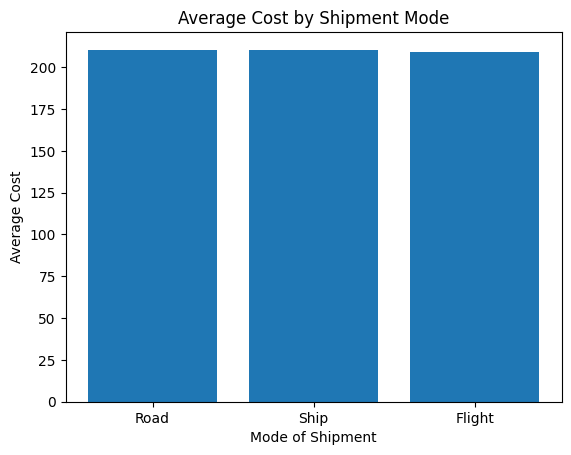

In [23]:
# Visualize the results


plt.bar(result1["Mode_of_Shipment"], result1["Avg_Cost"])
plt.title("Average Cost by Shipment Mode")
plt.xlabel("Mode of Shipment")
plt.ylabel("Average Cost")
plt.show()

In [24]:
df = df.rename(columns={"Reached.on.Time_Y_N": "Late_Indicator"})
df["Date"] = pd.to_datetime(df["Date"])
tsi_df["observation_date"] = pd.to_datetime(tsi_df["observation_date"])

In [25]:
assert df["ID"].is_unique
assert tsi_df["observation_date"].is_unique
print("Schema check passed")

Schema check passed


In [26]:
# Check structure 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   10999 non-null  int64         
 1   Warehouse_block      10999 non-null  object        
 2   Mode_of_Shipment     10999 non-null  object        
 3   Customer_care_calls  10999 non-null  int64         
 4   Customer_rating      10999 non-null  int64         
 5   Cost_of_the_Product  10999 non-null  int64         
 6   Prior_purchases      10999 non-null  int64         
 7   Product_importance   10999 non-null  object        
 8   Gender               10999 non-null  object        
 9   Discount_offered     10999 non-null  int64         
 10  Weight_in_gms        10999 non-null  int64         
 11  Late_Indicator       10999 non-null  int64         
 12  Date                 10999 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(8),

In [27]:
df.shape

(10999, 13)

In [28]:
# Summary statistics

df.describe(include="all") 

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Late_Indicator,Date
count,10999.00000,10999,10999,10999.000000,10999.000000,10999.000000,10999.000000,10999,10999,10999.000000,10999.000000,10999.000000,10999
unique,NaN,5,3,NaN,NaN,NaN,NaN,3,2,NaN,NaN,NaN,NaN
top,NaN,F,Ship,NaN,NaN,NaN,NaN,low,F,NaN,NaN,NaN,NaN
freq,NaN,3666,7462,NaN,NaN,NaN,NaN,5297,5545,NaN,NaN,NaN,NaN
mean,5500.00000,NaN,NaN,4.054459,2.990545,210.196836,3.567597,NaN,NaN,13.373216,3634.016729,0.596691,2035-01-21 00:00:00
min,1.00000,NaN,NaN,2.000000,1.000000,96.000000,2.000000,NaN,NaN,1.000000,1001.000000,0.000000,2020-01-01 00:00:00
25%,2750.50000,NaN,NaN,3.000000,2.000000,169.000000,3.000000,NaN,NaN,4.000000,1839.500000,0.000000,2027-07-12 12:00:00
50%,5500.00000,NaN,NaN,4.000000,3.000000,214.000000,3.000000,NaN,NaN,7.000000,4149.000000,1.000000,2035-01-21 00:00:00
75%,8249.50000,NaN,NaN,5.000000,4.000000,251.000000,4.000000,NaN,NaN,10.000000,5050.000000,1.000000,2042-08-01 12:00:00
max,10999.00000,NaN,NaN,7.000000,5.000000,310.000000,10.000000,NaN,NaN,65.000000,7846.000000,1.000000,2050-02-10 00:00:00


In [45]:
# Missing values

df.isnull().sum()

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Late_Indicator         0
Date                   0
_OnTime                0
dtype: int64

In [30]:
# Duplicate rows

df.duplicated().sum()

np.int64(0)

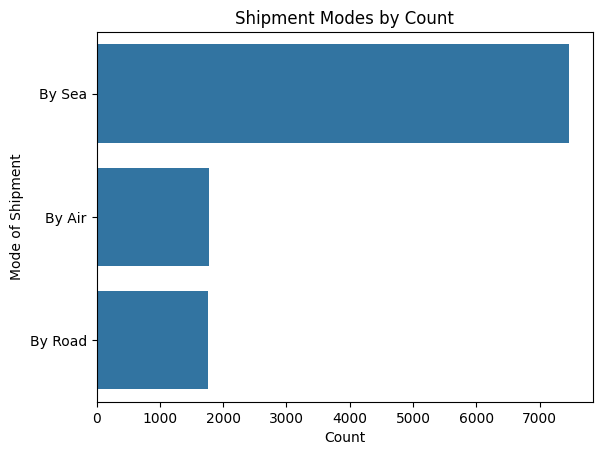

In [44]:
mode_mapping ={
    "Flight": "By Air",
    "Ship": "By Sea",
    "Road": "By Road"
}

df['Mode_of_Shipment'] = df['Mode_of_Shipment'].replace(mode_mapping)

top_carriers = df['Mode_of_Shipment'].value_counts().head(10)

sns.countplot(data=df, y="Mode_of_Shipment", order=df["Mode_of_Shipment"].value_counts().index)
              
plt.title("Shipment Modes by Count")
plt.xlabel("Count"); plt.ylabel("Mode of Shipment")
plt.ylabel("Mode of Shipment")


plt.savefig("../reports/shipment_modes.png", dpi=300, bbox_inches="tight")
plt.show()

### Bar Plot: Shipment Modes
# Why: To understand which shipment mode is most frequently used.  
# How: Replaced raw labels (Flight, Ship, Road) with descriptive labels (By Air, By Sea, By Road) and plotted their frequencies.  
# What I See: By far the most common mode of shipment is By Sea, followed by By Air and By Road.  
# Next Question**: Do delivery delays or customer ratings differ depending on the shipment mode?



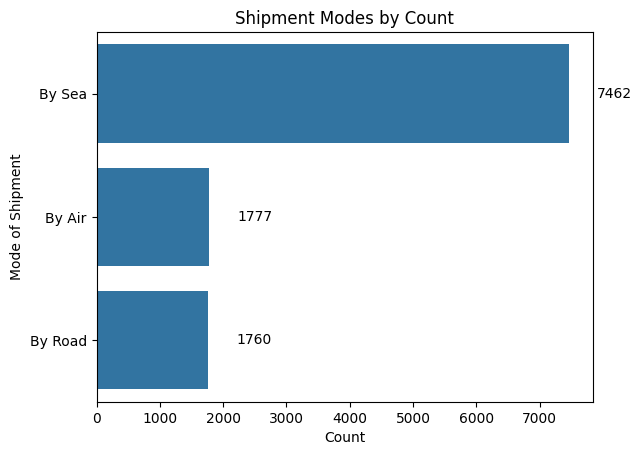

In [43]:
# Optional: relabel for clarify

mode_map = {"Flight": "By Air", "Ship": "By Sea", "Road": "By Road"}
df["Mode_of_Shipment"] = df["Mode_of_Shipment"].replace(mode_map)

counts = df["Mode_of_Shipment"].value_counts()
ax = sns.barplot(x=counts.values, y=counts.index)
ax.set_title("Shipment Modes by Count")
ax.set_xlabel("Count"); 
ax.set_ylabel("Mode of Shipment")

# Add number labels at the end of each bar

for i, v in enumerate(counts.values):
    ax.text(v + counts.max()*0.06, i, str(v), va="center")
    
    
plt.savefig("../reports/plots/01_shipment_modes.png", dpi=300, bbox_inches="tight")
plt.show()



# Notebook note (example):
# What I did: Counted shipments by transport mode.
# Why: To see which transport is used most.
# Insight: “By Sea” dominates; “By Air” and “By Road” are much smaller.

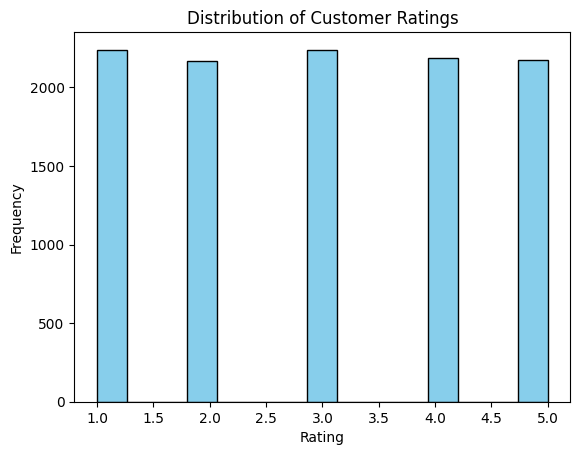

In [33]:


plt.hist(df['Customer_rating'], bins=15, color='skyblue', edgecolor='black')
plt.title("Distribution of Customer Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")

plt.savefig("../reports/plots/02_customer_rating_distribution.png", dpi=300, bbox_inches="tight")
plt.show()


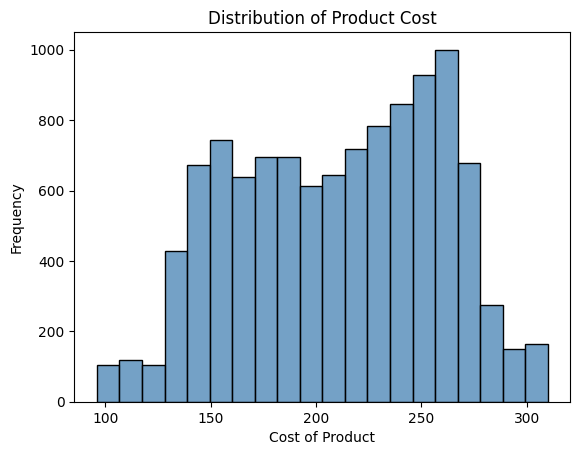

In [34]:
sns.histplot(df["Cost_of_the_Product"], bins=20, color="steelblue", edgecolor="black", kde=False)
plt.title("Distribution of Product Cost")
plt.xlabel("Cost of Product")
plt.ylabel("Frequency")

plt.savefig("../reports/plots/03_product_cost_distribution.png", dpi=300, bbox_inches="tight")

plt.show()

# Histogram: Product Cost
# Why**: To understand the range and distribution of product prices.
# How**: Plotted a histogram of `Cost_of_the_Product` with 20 bins.
# What I see: Most products cost between 150–250, with fewer at the very low (100–130) and high (280–310) ranges.
# Next Question**: Do higher-cost products experience more delays or receive higher/lower discounts?

C:\Users\jblev\AppData\Local\Temp\ipykernel_9620\2104429942.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Customer_rating", data=df, palette="Blues")


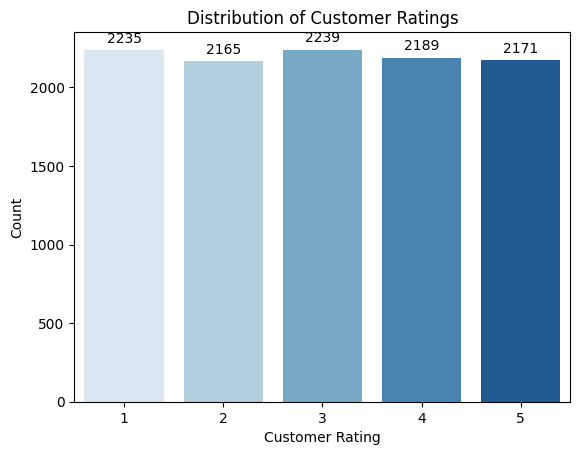

In [35]:
ax = sns.countplot(x="Customer_rating", data=df, palette="Blues")
ax.set_title("Distribution of Customer Ratings")
ax.set_xlabel("Customer Rating")
ax.set_ylabel("Count")

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, 
            p.get_height() + 50, 
            int(p.get_height()), 
            ha="center")
    
plt.savefig("../reports/plots/04_customer_rating_distribution.png", dpi=300, bbox_inches="tight")
plt.show()


# Histogram: Customer Ratings
# Why: To see how customers rate courier services (scale 1–5).  
# How: Counted ratings and plotted as bars. Added labels for clarity.  
# What I see: Ratings are fairly evenly spread, with each category having ~2,200 responses. No clear bias toward positive or negative ratings.  
# Next Question: Does rating vary by shipment mode (e.g., are "By Air" shipments rated better than "By Sea")?

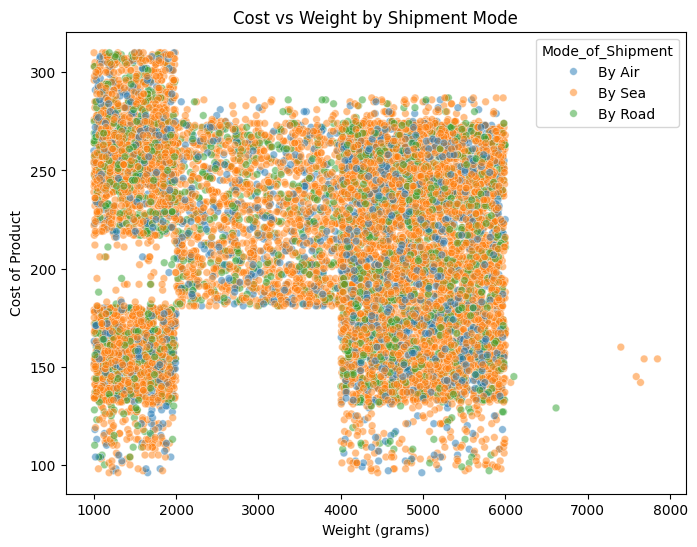

In [36]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x="Weight_in_gms",
    y="Cost_of_the_Product",
    hue="Mode_of_Shipment",
    alpha=0.5,
    s=30
)

plt.title("Cost vs Weight by Shipment Mode")
plt.xlabel("Weight (grams)")
plt.ylabel("Cost of Product")

plt.savefig("../reports/plots/05_cost_vs_weight.png", dpi=300, bbox_inches="tight")
plt.show()
 


# Scatter Plot: Cost vs Weight
# Why: To check if heavier products tend to cost more, and whether shipment mode has any effect.  
# How: Plotted product weight (x-axis) against cost (y-axis), with colors for shipment mode.  
# What I see: Costs are spread fairly evenly between $100–$300 regardless of weight. No clear linear relationship. Shipment mode (Air, Sea, Road) does not appear to strongly influence cost.  
# Next Question: Do discounts depend more on product weight than cost? Or do certain shipment modes handle heavier items differently?

C:\Users\jblev\AppData\Local\Temp\ipykernel_9620\3499566787.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Mode_of_Shipment", y="Discount_offered", palette="Set2")


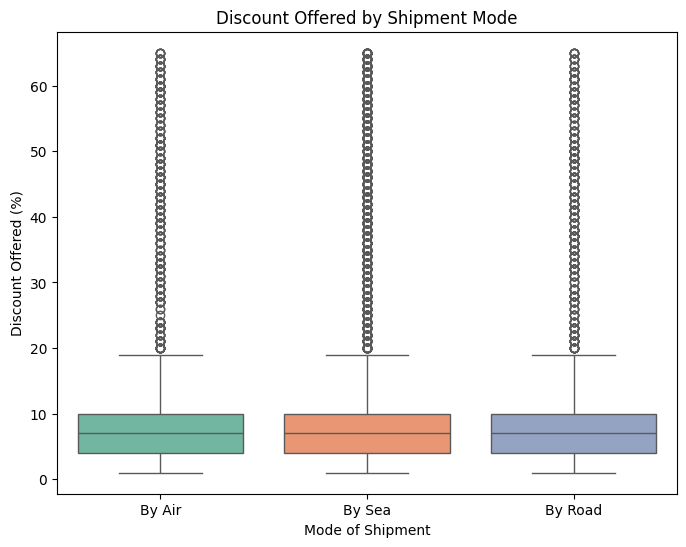

In [37]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x="Mode_of_Shipment", y="Discount_offered", palette="Set2")
plt.title("Discount Offered by Shipment Mode")
plt.xlabel("Mode of Shipment")
plt.ylabel("Discount Offered (%)")

plt.savefig("../reports/plots/06_discounts_by_mode.png", dpi=300, bbox_inches="tight")
plt.show()

C:\Users\jblev\AppData\Local\Temp\ipykernel_9620\3265373091.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Mode_of_Shipment", y="Customer_care_calls", palette="Set3")


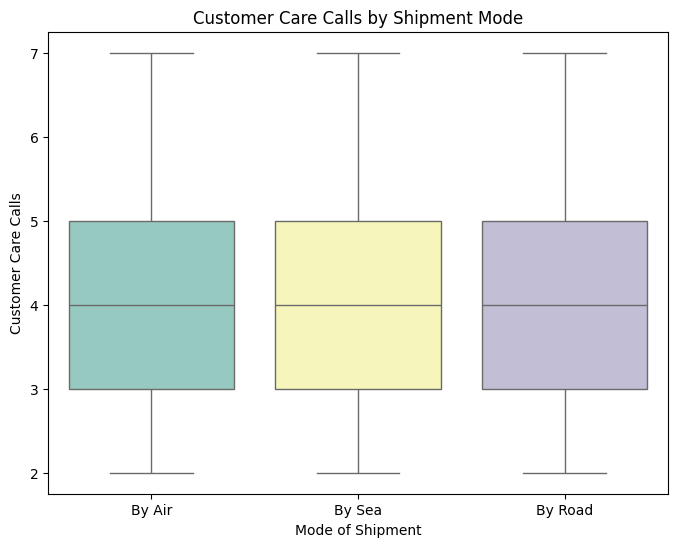

In [38]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x="Mode_of_Shipment", y="Customer_care_calls", palette="Set3")
plt.title("Customer Care Calls by Shipment Mode")
plt.xlabel("Mode of Shipment")
plt.ylabel("Customer Care Calls")

plt.savefig("../reports/plots/07_calls_by_mode.png", dpi=300, bbox_inches="tight")
plt.show()

# Boxplot: Customer Care Calls by Shipment Mode

# Why: To check if certain shipping methods cause more customer service interactions.

# How: Created a boxplot of Customer_care_calls grouped by Mode_of_Shipment.

# What I see: The median is consistently 4 calls across all modes. The spread is also
# nearly identical (2-7 calls). This suggests that shipment mode does not significantly
# impact the number of customer service calls.

# Next Question: Are higher call volumes related more to delivery delays (on-time vs
# late) than to shipment mode?

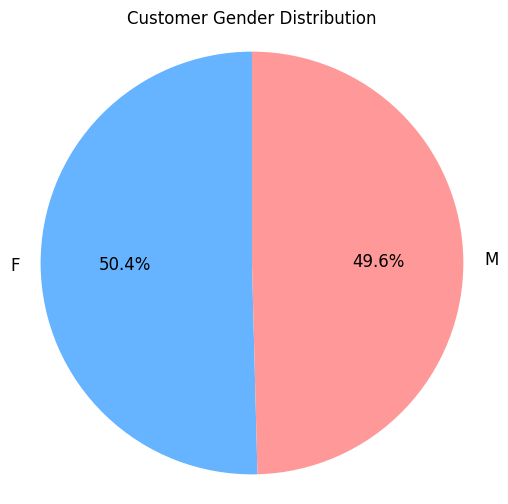

In [39]:
gender_counts = df["Gender"].value_counts()

plt.figure(figsize=(6,6))
plt.pie(
    gender_counts,
    labels=gender_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=["#66b3ff", "#ff9999"], 
    textprops={"fontsize": 12}
)
plt.title("Customer Gender Distribution")
plt.axis("equal") 


plt.savefig("../reports/plots/08_gender_distribution.png", dpi=300, bbox_inches="tight")
plt.show()
                                          

# Pie Chart: Gender Distribution
# Why: To check whether male and female customers are equally represented.  
# How: Plotted a pie chart of `Gender` counts.  
# What I see: The dataset is nearly evenly split: 50.4% female and 49.6% male. This means gender will not strongly bias shipment analysis.  
# Next Question: Does gender correlate with shipment mode preference or product importance?


C:\Users\jblev\AppData\Local\Temp\ipykernel_9620\3333359506.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x="_OnTime", palette="pastel")


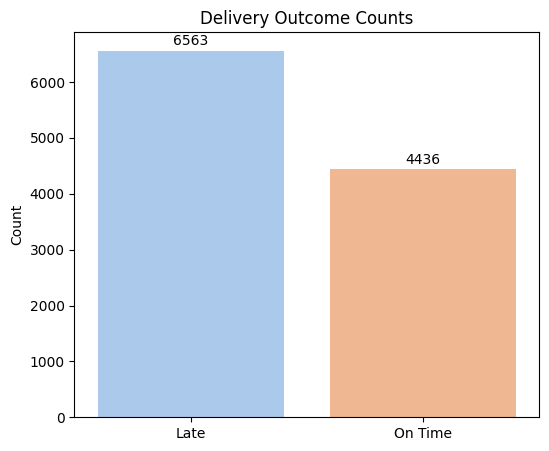

In [40]:
# Map to readable labels 

df["_OnTime"] = df["Late_Indicator"].map({0: "On Time", 1: "Late"})

plt.figure(figsize=(6,5))
ax = sns.countplot(data=df, x="_OnTime", palette="pastel")

# Add title/labels
ax.set_title("Delivery Outcome Counts")
ax.set_xlabel("")
ax.set_ylabel("Count")

# Add labels on bars
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2,
            p.get_height() + 100,
            int(p.get_height()),
            ha="center")

# Save figure
plt.savefig("../reports/plots/09_delivery_outcomes.png", dpi=300, bbox_inches="tight")
plt.show()
                       

# Count Plot: Delivery Outcomes
# Why: To measure delivery performance (on-time vs late).  
# How: Mapped `Reached.on.Time_Y.N` into "On Time" and "Late". Counted each outcome.  
# What I see: Only ~60% of shipments are on time, while ~40% are late.  
# Next Question: Which factors (shipment mode, product weight, cost, discount) influence late deliveries most strongly?


In [41]:
print("Database created successfully with both tables.")


Database created successfully with both tables.


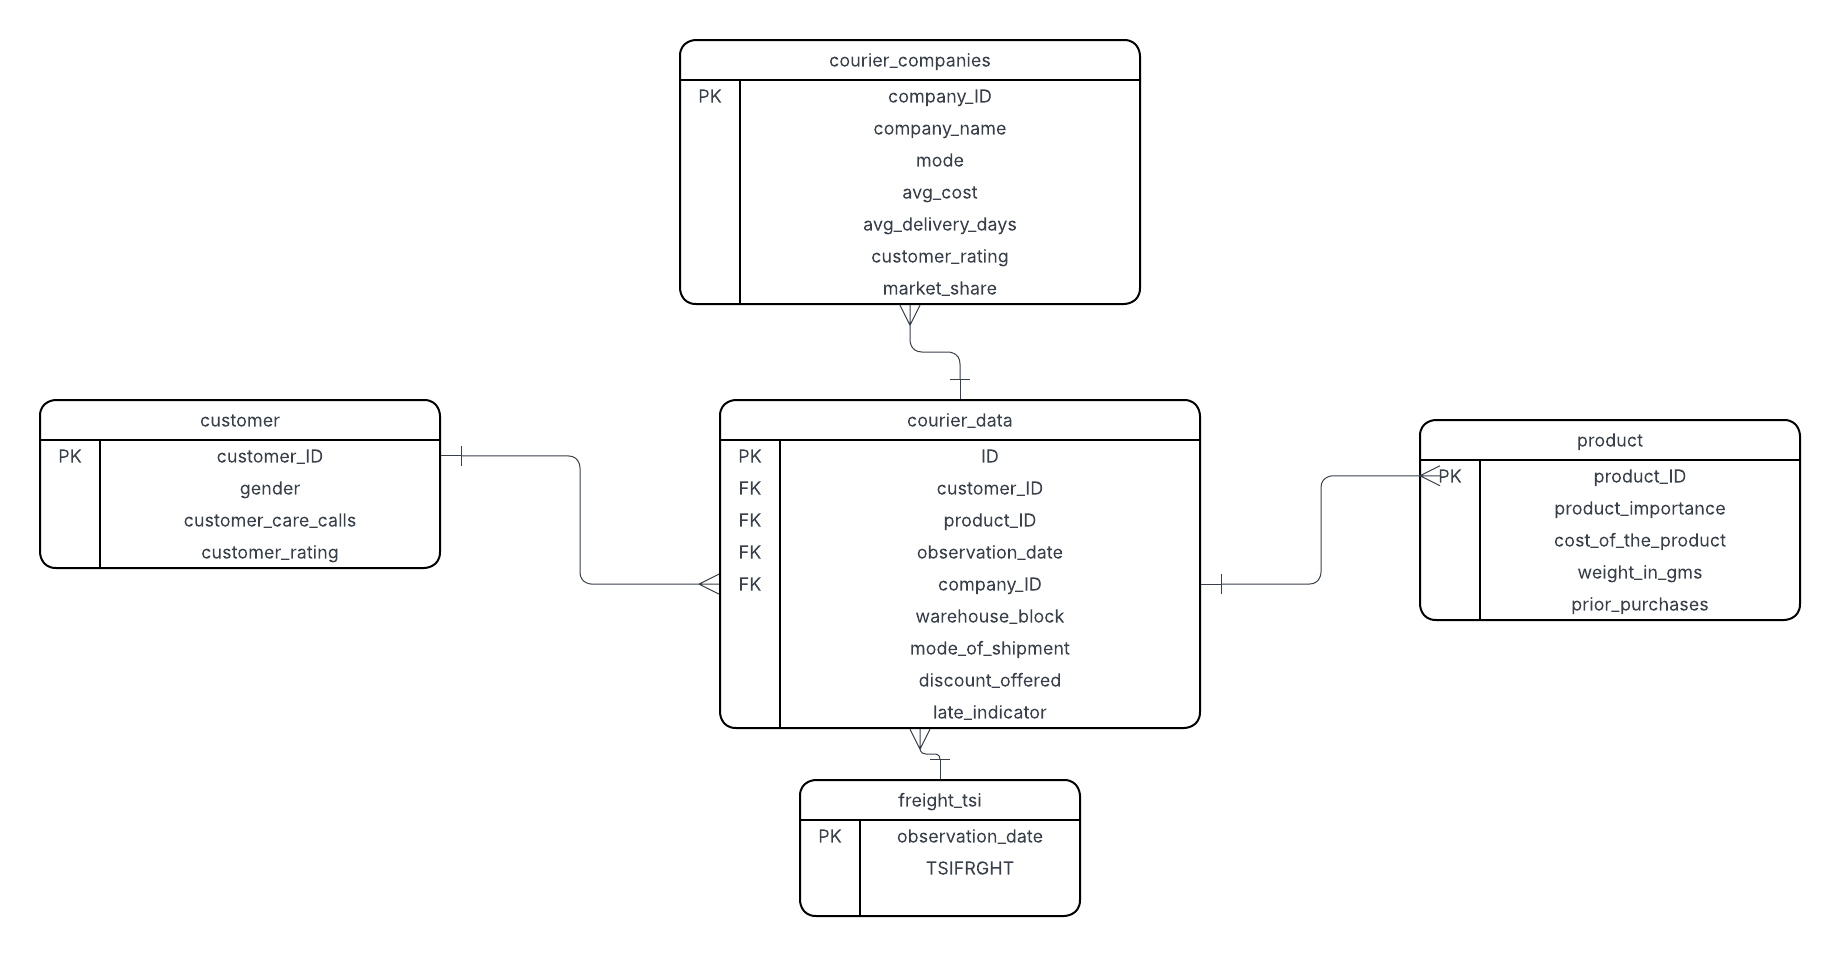

In [42]:
from IPython.display import Image
Image("../reports/images/courier_service_ERD.png")

## ERD Justification ##

The database is normalized into multiple related tables:

- **courier_data** stores shipment-level records (date, mode, discount, late indicator).
- **courier_companies** adds company-level info (name, avg cost, avg delivery days, market share).
- **customer** and **product** store entity-specific attributes that repeat across shipments.
- **freight_tsi** connects the external freight index by date.

Keys like `customer_ID`, `product_ID`, and `company_ID`, plus the date fields, let us join the tables together.  
This structure reduces redundancy and supports the SQL analysis we did (by mode, by company, and by competitiveness).

## Conclusion ##

Throught this project, we build a relational database to analyze courier service performance. 
By combining shipment-level data, company information, and freight trends, we were able to explore efficiency and competitiveness.

Query 1 showed that Ship mode provided the most reliable deliveries, though at slightly higher cost.
Query 2 revealed differences in performance among courier companies - identifying which firms achieved higher ratings and lower late ratios.  
Query 3 compared competitiveness factors, showing how discounts and delivery reliability vary by company. 

This analysis demostrates how SQL and Python can be used together to uncover insights from logistics data.
Future steps could include adding customer segmentation or predicting delivery delays using machine learning.